# Comparing Networks

In this notebook, we want to compare different network to each other.
We will start of with...

- Untrained Model
- Trained Model
- Trained Model (Exact Unlearning)*$^1$

All these model should serve as comparison point for approximate MU Algorithms, which we want to try out

*$^1$ Exact Unlearning: refers to an complete retraining of the Model, without the samples which we want to unlearn.

In [1]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np
# from helper import get_model TODO Muss überarbeitet werden
from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

ALLREADY_TRAINED = True

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    classes=["7"],
    dataset_name = USED_DATASET,
    download=True,
)

c:\Users\Moritz\miniconda3\envs\bach.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

We want to include an untrained model as a pour reference point.

Later, we will compare the differently trained (and untrained) models on different metrics. We are thinking, that the **untrained model should always be the furthest neighbor** and see if thats true. Also out of pur curiosity, how do the models compare according to the found metrics to the untrained model.

It could be interesting to see, if the unlearned models tend to be more similar to the "Exact MU Model" or to the "Untrained Model"

The "Trained Model"´s and "Exact Model"´s starting point is the "Untrained Model". That means all models can be traced back to it.

In [3]:
from training import save_model

if not ALLREADY_TRAINED:
    untrained_model = TwoLayerPerceptron() if USED_DATASET in ["mnist", "fashion_mnist"] else ConvNet()
    # save it first
    save_model(untrained_model, name="showcase_untrained", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained", logs=False)

    untrained_ms = {v: TwoLayerPerceptron() for v in range(30)} if USED_DATASET in ["mnist", "fashion_mnist"] else {v: ConvNet() for v in range(30)}

    for i, model in untrained_ms.items():
        save_model(model=model, name=i, path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        untrained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        untrained_showcase_all = ConvNet()
    name = str(untrained_showcase_all)
    untrained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained",
            weights_only=True
            )
        )
    untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model

This model will be the starting point for all MU algorithms. The more it is important that it does not change throughout the experiments, otherwise we need to run everything again.

Notes Regarding the Dataloader: We included Up-/Downsampling. There is a counter in the Dataset class, which controls, which class is next to provide a sample. From the available pool a sample will be chosen at random.

Reason: The amount of available samples should not influence the performance of the model on certain classes.

Regarding the samples for the class "7": There are more samples of sevens without a middle line than ones with.

Ratio: 
- 6268 (train: 5385, test: 883)
- 1025 (train: 880,  test: 145)

Should there be concerns regarding that the bigger part of the sevens (without middle line) will be unlearning?

In [4]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_all = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="all",
        balanced=True,
        dataset_name="fashion_mnist",
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_all = ConvNet()
    name = str(trained_showcase_all)
    trained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase",
            weights_only=True
            )
        )

In [5]:
if not ALLREADY_TRAINED:
    trained_ms = train_n_models(
        sampling_mode="all",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Unlearned Model

This model has the same training conditions as the "Trained Model", with the only difference being, that it had no sevens __with no middle line__

In [6]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_except = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="except_erased",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_except= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_except = ConvNet()
    name = str(trained_showcase_except)
    trained_showcase_except.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}{name}_b_trained_showcase",
            weights_only=True
            )
        )

In [7]:
if not ALLREADY_TRAINED:
    exact_ms = train_n_models(
        sampling_mode="except_erased",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

In [8]:
from metrics import calc_accuracy
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [9]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [13]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.640473065428022

In [14]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a12

27.650029139651192

#### Trained to ...

In [15]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a21

28.440761721454976

#### Exact to ...

In [16]:
# see above

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [17]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Unlearned to...

In [18]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.8423793361191256

In [19]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.762969458950557

#### Trained to...

In [20]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.1184463151948718

In [21]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.03437059730577239

#### Exact to...

In [22]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.01793968250926

In [23]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.03655367984054544

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [24]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.1019 - Standard Deviation for D_gesamt: 0.0285


Average Accuracy for D_remain: 0.1019 - Standard Deviation for D_remain: 0.0288


Average Accuracy for 0: 0.0939 - Standard Deviation for 0: 0.1675


Average Accuracy for 1: 0.1119 - Standard Deviation for 1: 0.1667


Average Accuracy for 2: 0.1021 - Standard Deviation for 2: 0.1739


Average Accuracy for 3: 0.1926 - Standard Deviation for 3: 0.2478


Average Accuracy for 4: 0.0578 - Standard Deviation for 4: 0.0874


Average Accuracy for 5: 0.0507 - Standard Deviation for 5: 0.0711


Average Accuracy for 6: 0.1161 - Standard Deviation for 6: 0.1779


Average Accuracy for 8: 0.1091 - Standard Deviation for 8: 0.1844


Average Accuracy for 9: 0.0773 - Standard Deviation for 9: 0.1464


Average Accuracy for 7_all: 0.0982 - Standard Deviation for 7_all: 0.1467


Average Accuracy for 7_remain: 0.0984 - Standard Deviation for 7_remain: 0.1504


Average Accuracy for 7_erased: 0.0964 - Standard Deviation for 7_erased: 0.1363
plotting...


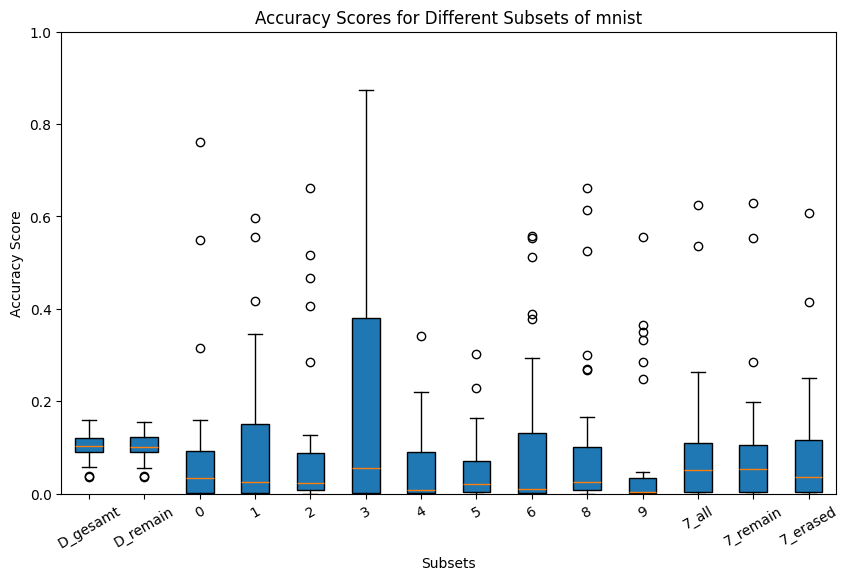

In [25]:
# Macht vllt ned so viel Sinn, fand i nur witzig
accs["untrained_ms"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="accuracy", logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8712 - Standard Deviation for D_gesamt: 0.0009


Average Accuracy for D_remain: 0.8747 - Standard Deviation for D_remain: 0.0009


Average Accuracy for 0: 0.9477 - Standard Deviation for 0: 0.0012


Average Accuracy for 1: 0.9570 - Standard Deviation for 1: 0.0016


Average Accuracy for 2: 0.8367 - Standard Deviation for 2: 0.0029


Average Accuracy for 3: 0.8461 - Standard Deviation for 3: 0.0026


Average Accuracy for 4: 0.8758 - Standard Deviation for 4: 0.0057


Average Accuracy for 5: 0.7671 - Standard Deviation for 5: 0.0059


Average Accuracy for 6: 0.9261 - Standard Deviation for 6: 0.0015


Average Accuracy for 8: 0.8103 - Standard Deviation for 8: 0.0024


Average Accuracy for 9: 0.8428 - Standard Deviation for 9: 0.0036


Average Accuracy for 7_all: 0.8820 - Standard Deviation for 7_all: 0.0022


Average Accuracy for 7_remain: 0.9223 - Standard Deviation for 7_remain: 0.0021


Average Accuracy for 7_erased: 0.6259 - Standard Deviation for 7_erased: 0.0082
plotting...


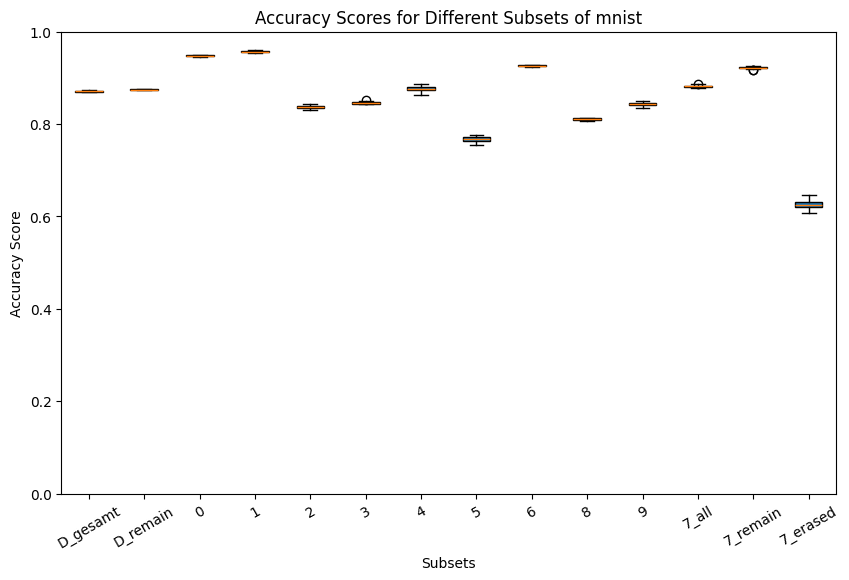

In [26]:
# can take like 80minutes
accs["trained_ms"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="accuracy", logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8694 - Standard Deviation for D_gesamt: 0.0009


Average Accuracy for D_remain: 0.8754 - Standard Deviation for D_remain: 0.0009


Average Accuracy for 0: 0.9479 - Standard Deviation for 0: 0.0015


Average Accuracy for 1: 0.9567 - Standard Deviation for 1: 0.0023


Average Accuracy for 2: 0.8400 - Standard Deviation for 2: 0.0030


Average Accuracy for 3: 0.8486 - Standard Deviation for 3: 0.0029


Average Accuracy for 4: 0.8746 - Standard Deviation for 4: 0.0049


Average Accuracy for 5: 0.7625 - Standard Deviation for 5: 0.0052


Average Accuracy for 6: 0.9261 - Standard Deviation for 6: 0.0020


Average Accuracy for 8: 0.8130 - Standard Deviation for 8: 0.0041


Average Accuracy for 9: 0.8470 - Standard Deviation for 9: 0.0038


Average Accuracy for 7_all: 0.8578 - Standard Deviation for 7_all: 0.0023


Average Accuracy for 7_remain: 0.9218 - Standard Deviation for 7_remain: 0.0018


Average Accuracy for 7_erased: 0.4508 - Standard Deviation for 7_erased: 0.0126
plotting...


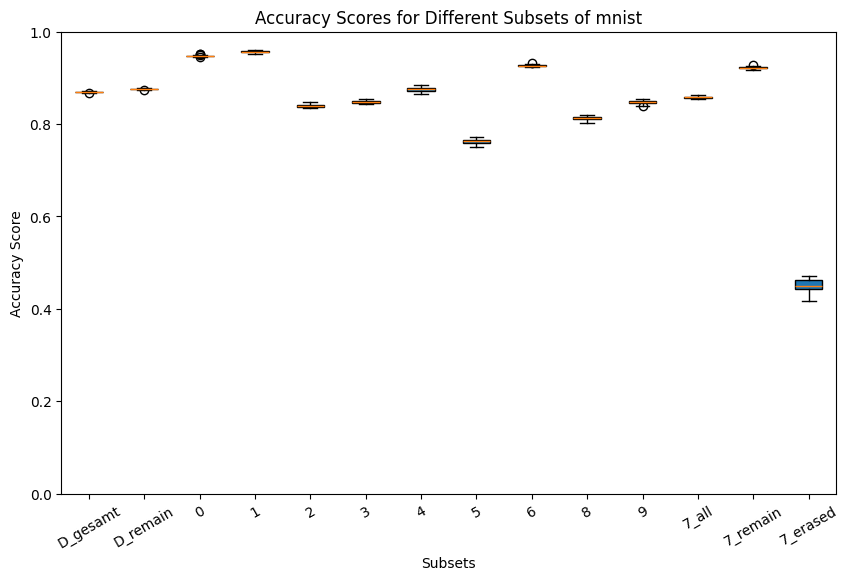

In [27]:
# can take like 80minutes
accs["exact_ms"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="accuracy", logs=True)

#### Losses

In [28]:
losses = {}

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.2881 - Standard Deviation for D_gesamt: 0.0010


Average Accuracy for D_remain: 0.2882 - Standard Deviation for D_remain: 0.0010


Average Accuracy for 0: 0.2867 - Standard Deviation for 0: 0.0072


Average Accuracy for 1: 0.2876 - Standard Deviation for 1: 0.0065


Average Accuracy for 2: 0.2872 - Standard Deviation for 2: 0.0066


Average Accuracy for 3: 0.2858 - Standard Deviation for 3: 0.0093


Average Accuracy for 4: 0.2904 - Standard Deviation for 4: 0.0081


Average Accuracy for 5: 0.2909 - Standard Deviation for 5: 0.0071


Average Accuracy for 6: 0.2888 - Standard Deviation for 6: 0.0080


Average Accuracy for 8: 0.2878 - Standard Deviation for 8: 0.0079


Average Accuracy for 9: 0.2901 - Standard Deviation for 9: 0.0081


Average Accuracy for 7_all: 0.2878 - Standard Deviation for 7_all: 0.0057


Average Accuracy for 7_remain: 0.2878 - Standard Deviation for 7_remain: 0.0057


Average Accuracy for 7_erased: 0.2878 - Standard Deviation for 7_erased: 0.0061
plotting...


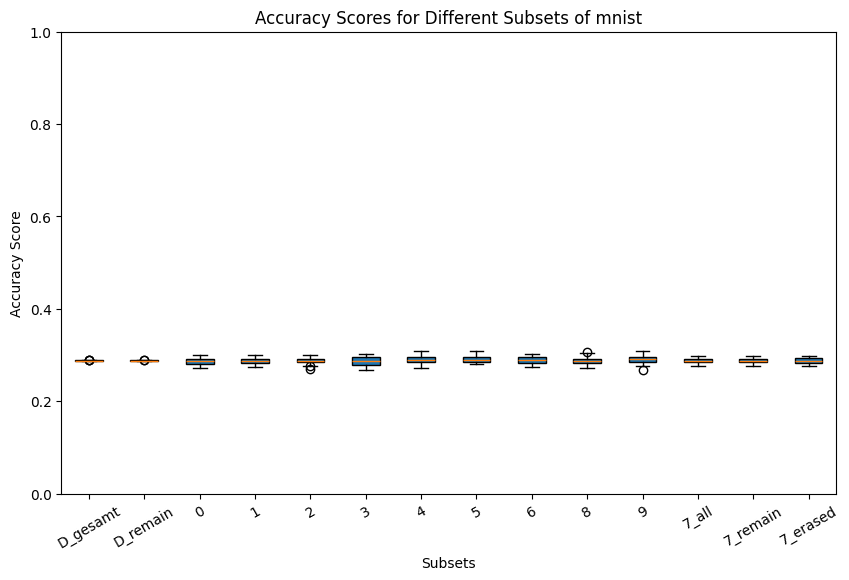

In [29]:
losses["untrained_ms"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="loss", logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.0739 - Standard Deviation for D_gesamt: 0.0003


Average Accuracy for D_remain: 0.0728 - Standard Deviation for D_remain: 0.0003


Average Accuracy for 0: 0.0399 - Standard Deviation for 0: 0.0005


Average Accuracy for 1: 0.0474 - Standard Deviation for 1: 0.0008


Average Accuracy for 2: 0.0749 - Standard Deviation for 2: 0.0011


Average Accuracy for 3: 0.0808 - Standard Deviation for 3: 0.0010


Average Accuracy for 4: 0.0786 - Standard Deviation for 4: 0.0012


Average Accuracy for 5: 0.1124 - Standard Deviation for 5: 0.0013


Average Accuracy for 6: 0.0490 - Standard Deviation for 6: 0.0007


Average Accuracy for 8: 0.0968 - Standard Deviation for 8: 0.0009


Average Accuracy for 9: 0.0995 - Standard Deviation for 9: 0.0011


Average Accuracy for 7_all: 0.0670 - Standard Deviation for 7_all: 0.0008


Average Accuracy for 7_remain: 0.0540 - Standard Deviation for 7_remain: 0.0008


Average Accuracy for 7_erased: 0.1496 - Standard Deviation for 7_erased: 0.0025
plotting...


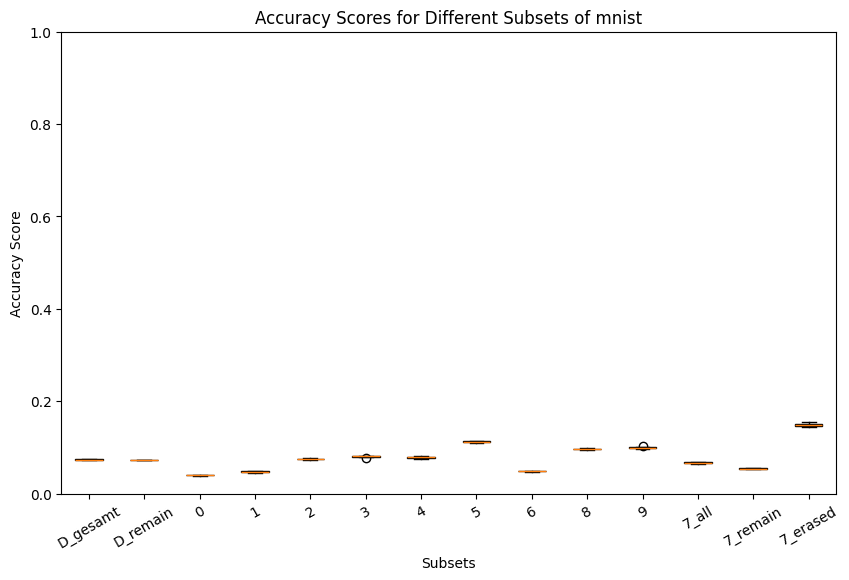

In [30]:
losses["trained_ms"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="loss", logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.0740 - Standard Deviation for D_gesamt: 0.0004


Average Accuracy for D_remain: 0.0721 - Standard Deviation for D_remain: 0.0004


Average Accuracy for 0: 0.0396 - Standard Deviation for 0: 0.0006


Average Accuracy for 1: 0.0469 - Standard Deviation for 1: 0.0010


Average Accuracy for 2: 0.0740 - Standard Deviation for 2: 0.0008


Average Accuracy for 3: 0.0801 - Standard Deviation for 3: 0.0012


Average Accuracy for 4: 0.0775 - Standard Deviation for 4: 0.0009


Average Accuracy for 5: 0.1132 - Standard Deviation for 5: 0.0013


Average Accuracy for 6: 0.0488 - Standard Deviation for 6: 0.0008


Average Accuracy for 8: 0.0957 - Standard Deviation for 8: 0.0011


Average Accuracy for 9: 0.0972 - Standard Deviation for 9: 0.0010


Average Accuracy for 7_all: 0.0739 - Standard Deviation for 7_all: 0.0010


Average Accuracy for 7_remain: 0.0539 - Standard Deviation for 7_remain: 0.0010


Average Accuracy for 7_erased: 0.2005 - Standard Deviation for 7_erased: 0.0033
plotting...


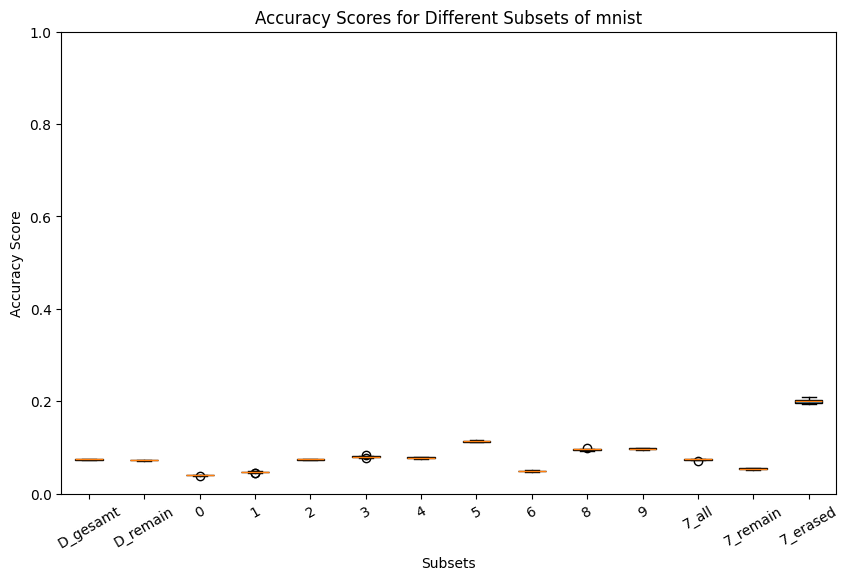

In [31]:
losses["exact_ms"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="loss", logs=True)